**Brief**

Write the architecture of a SimpleUNet following the diagram shown during the lecture/in GitHub:

Encoder: Define a convolutional block (conv_block) that will be repeated in each layer of the encoder. Define as well a maxpooling block (maxpool_block) that will also be repeated when necessary during the encoding (downsampling path). Hint: use torch.nn.Conv2d and remember you need to add by hand the activation function (use ReLU).

Middle: define the middle or bottleneck part of the architecture.

Decoder: Define the transposed convolutional blocks (transposed_block). Hint: use nn.ConvTranspose2d.

Final layer: Define the final convolutional layer.

Forward: Remember you need to define the forward pass of your class, with how each block will be called.

In order to aid the optimisation process, include batch normalisation (nn.BatchNorm2d) and 50% dropout (nn.Dropout2d(0.5)). Where do think they should be placed?

Note: There are different ways to build this architecture, here we will use PyTorch as we will test that we can load the pre-trained model provided.

In [52]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchmetrics
from torchsummary import summary
from torchmetrics.classification import BinaryAccuracy

import random
import cv2
import pydicom
from pydicom import dcmread

import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import pandas as pd

/var/folders/3z/b2kwzfld67jb1dnvys4q2t800000gn/T/ipykernel_5368/1218223657.py:22: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [22]:
# Deidentify the patient data
# Dataset path
images_path = 'Dataset/Images'

# Iterate through all the items in the directory specified by images_path
for Case in os.listdir(images_path):
    # Full path to current case item
    Case_path = os.path.join(images_path, Case)

    if os.path.isdir(Case_path):
        # List all files in the current Case_path that end with .dcm
        dicom_files = [file for file in os.listdir(Case_path) if file.endswith('.dcm')]

        # Sort the DICOM files - based on slice location
        dicom_files.sort()

        # Per patient
        print("****************************")
        print(f"Patient: {Case}")

        # Open the first DICOM file in the case path
        dicom_path = os.path.join(Case_path, dicom_files[0])

        # Read the DICOM file - imagedata and metadata
        dicom_data = pydicom.dcmread(dicom_path)
        print(dicom_data)
        print(dicom_data.SliceLocation)

****************************
Patient: Case_010
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 216
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7014.4598.200127877340702384320373311367
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
(0002, 0016) Source Application Entity Title     AE: 'DicomBrowser'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20050802'
(0008, 0013) Instance Cr

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_000
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 462.0 mm
(154, 512, 512) (154, 512, 512)


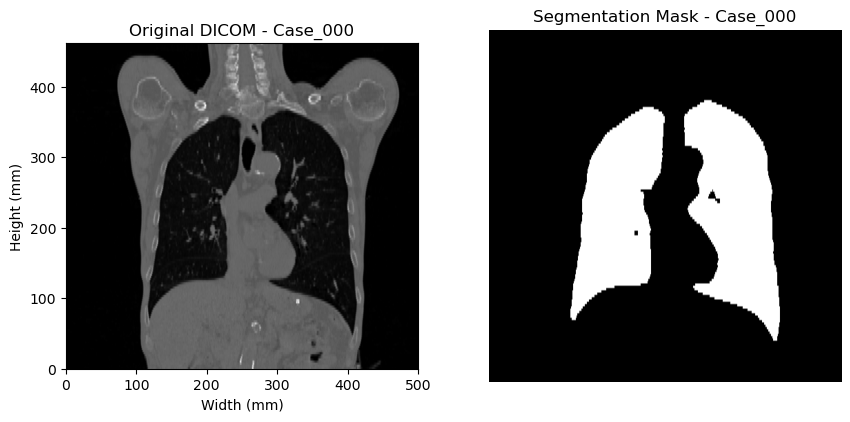

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_001
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 474.0 mm
(158, 512, 512) (158, 512, 512)


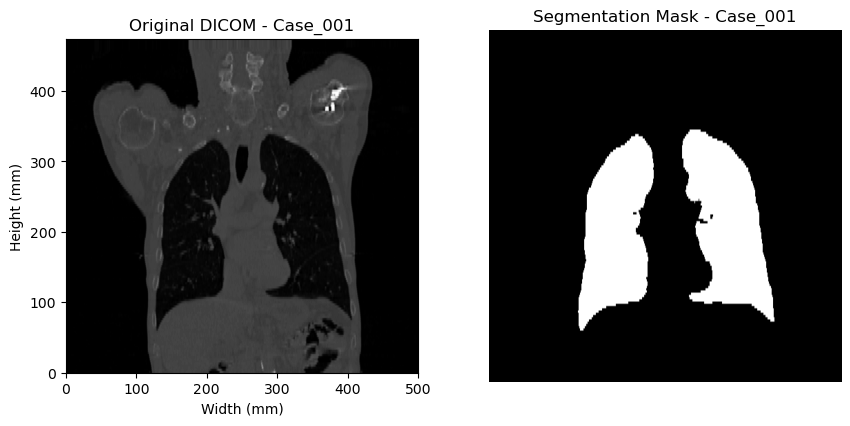

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_002
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 408.0 mm
(136, 512, 512) (136, 512, 512)


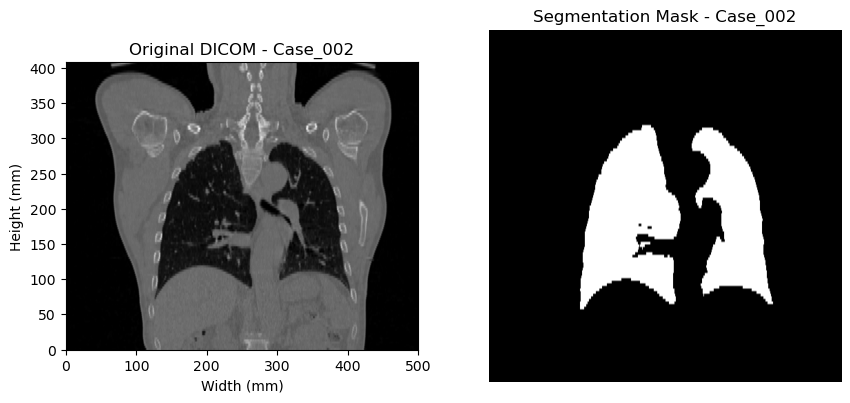

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_003
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 420.0 mm
(140, 512, 512) (140, 512, 512)


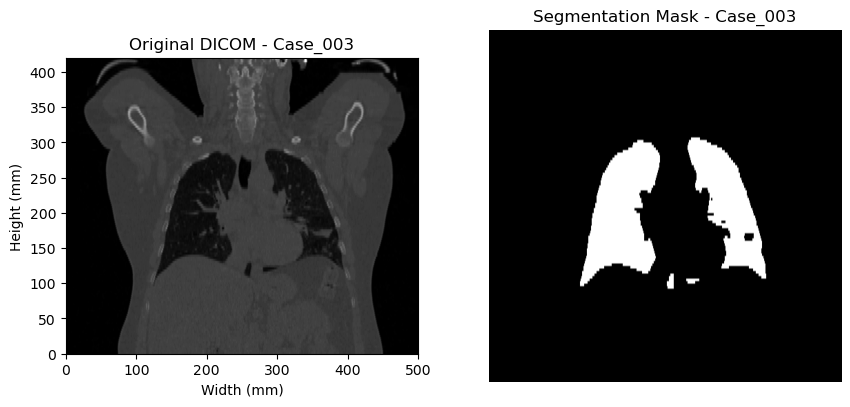

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_004
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 444.0 mm
(148, 512, 512) (148, 512, 512)


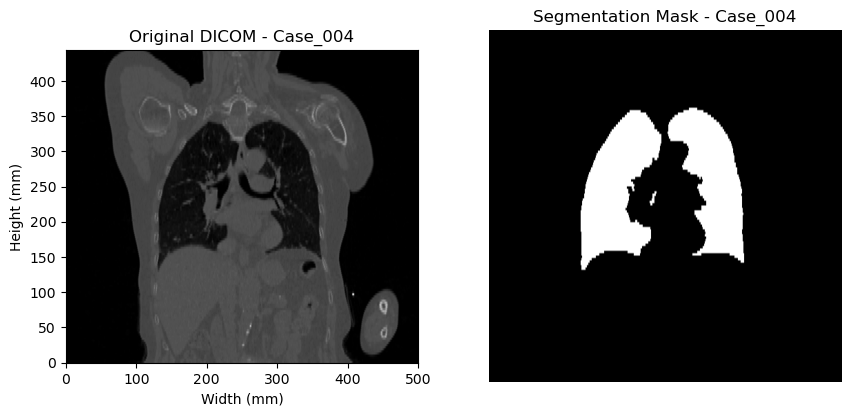

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_005
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 366.0 mm
(122, 512, 512) (122, 512, 512)


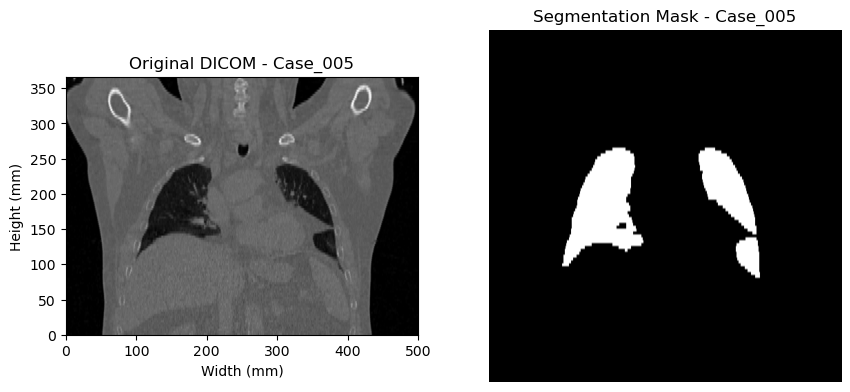

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_006
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 486.0 mm
(162, 512, 512) (162, 512, 512)


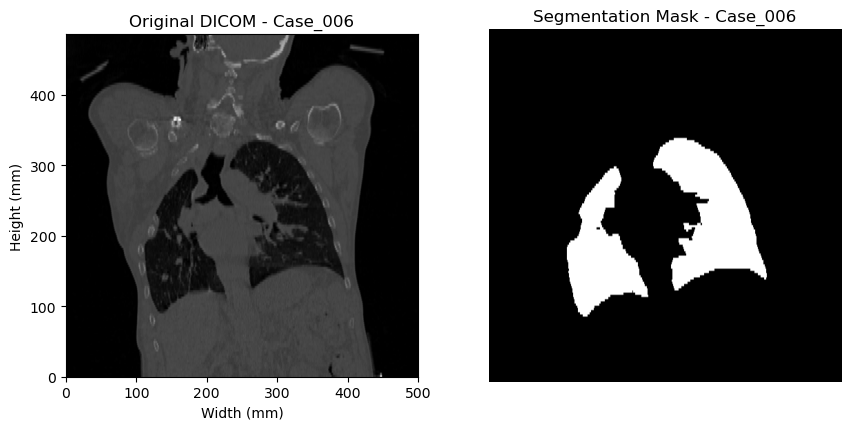

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_007
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 393.0 mm
(131, 512, 512) (131, 512, 512)


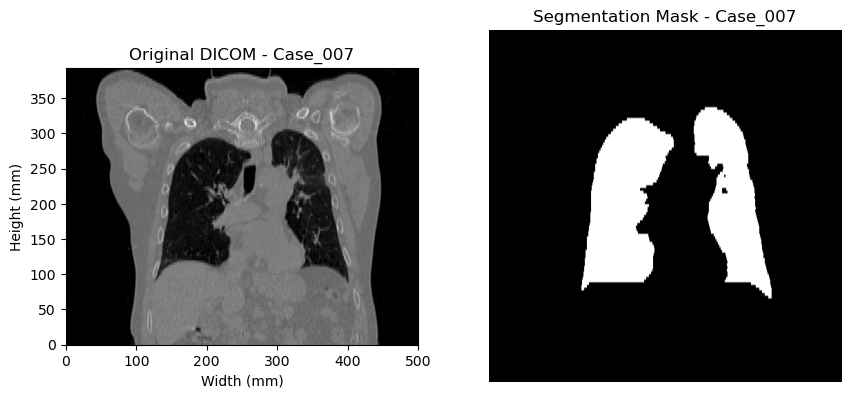

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_008
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 444.0 mm
(148, 512, 512) (148, 512, 512)


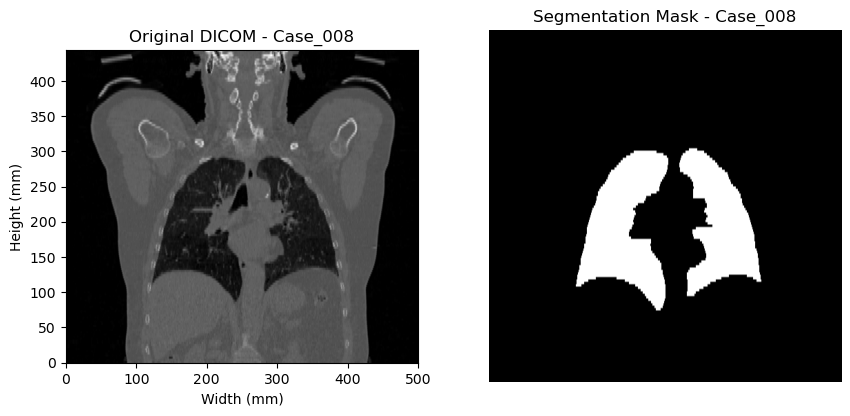

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_009
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 351.0 mm
(117, 512, 512) (117, 512, 512)


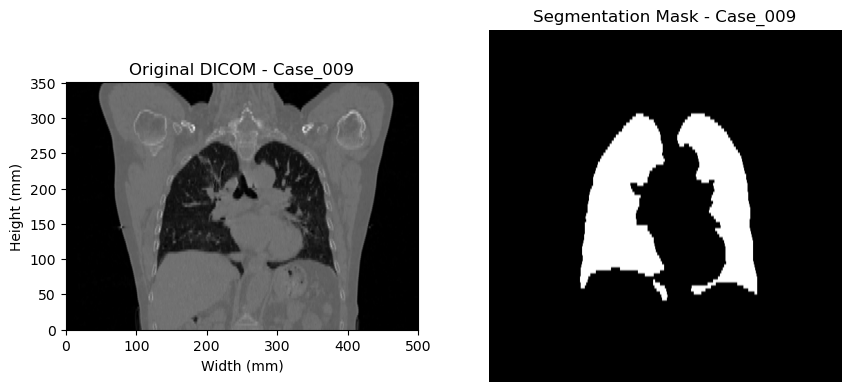

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_010
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 393.0 mm
(131, 512, 512) (131, 512, 512)


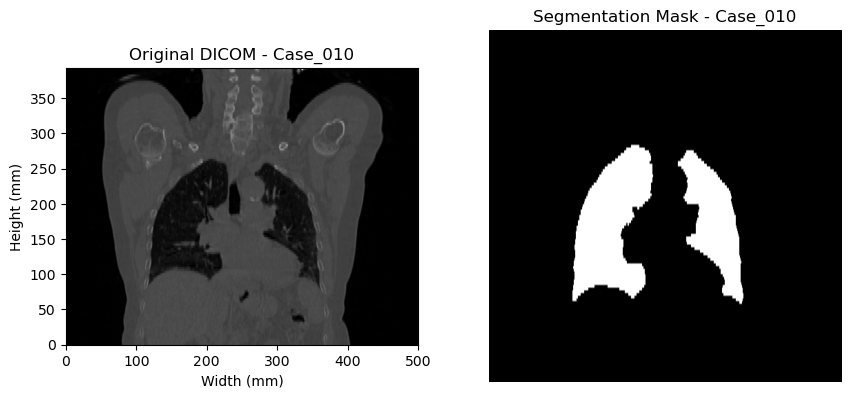

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
**************************
Patient: Case_011
X Dimension: 500.0 mm
Y Dimension: 500.0 mm
Z Dimension: 414.0 mm
(138, 512, 512) (138, 512, 512)


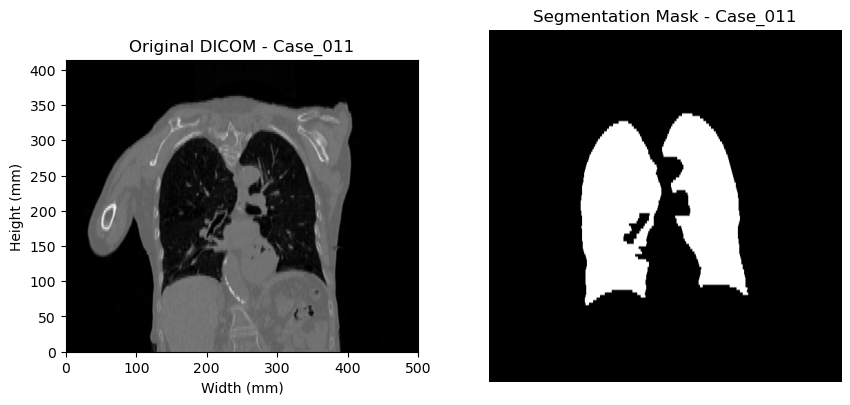

In [23]:
# Module 1 - Handling Dicom data
# Convert DICOM dataset (3D volume - 12 cases) into a NumPy array per case (patient)

# Dataset path
images_path = 'Dataset/Images'
segmentation_path = 'Dataset/Segmentations/'

# Sort the Segmentations by case number
for segmentation in sorted(os.listdir('Dataset/Segmentations/')):
    full_segmentation_path = os.path.join(segmentation_path, segmentation)

    # Load npz data
    segmentation_data = np.load(full_segmentation_path)

    # # List all keys in the npz files
    # keys = segmentation_data.files
    # print("Keys in the .npz file:", keys)

    # Extract masks and flip vertically
    mask_array = np.flipud(segmentation_data['masks'])
    print(mask_array)

    # Case is 0-7 digits of the segmentation
    Case = segmentation[:8]
    
    # Full path to current case item
    Case_path = os.path.join(images_path, Case)

    # List all files in the current Case_path that end with .dcm
    dicom_files = [file for file in os.listdir(Case_path) if file.endswith('.dcm')]

    # Sort the DICOM files - sort them by slice location
    dicom_files.sort()

    print("**************************")
    print(f"Patient: {Case}")
    
    dicom_info = []

    # Iterate over all dicom files
    for dicom_file in dicom_files:
        
        # Open the DICOM file in the case path
        dicom_path = os.path.join(Case_path, dicom_file)
        # Read the DICOM file - imagedata and metadata
        dicom_data = pydicom.dcmread(dicom_path)
        # Extract the slice information
        slice_location = getattr(dicom_data, 'SliceLocation', None)

        # Extract the pixel spacing and slice thickness
        slice_thickness = getattr(dicom_data, 'SliceThickness', None)
        pixel_spacing = getattr(dicom_data, 'PixelSpacing', None)

        if slice_location is not None:
            dicom_info.append((dicom_file, slice_location))

    # Sort the dicom files based on slice location
    dicom_info.sort(key=lambda x: x[1])
    dicom_array = []

    for dicom_file, _ in dicom_info:

        # Open the DICOM file in the case path
        dicom_path = os.path.join(Case_path, dicom_file)

        # Read the DICOM file - imagedata and metadata
        dicom_data = pydicom.dcmread(dicom_path)
        
        # Image data is extracted into a NumPy array
        arr = dicom_data.pixel_array

        # Rescaling into Hounsfield units for better visualisation
        rescale_slope = dicom_data.RescaleSlope
        rescale_intercept = dicom_data.RescaleIntercept

        # Convert to Hounsfield Units
        hu_arr = arr * rescale_slope + rescale_intercept

        # Append the NumPy arrays
        dicom_array.append(hu_arr)

    # Stack the 3D array and flip vertically
    # (number_of_slices, height_of_each_slice, width_of_each_slice)
    dicom_array_3d = np.flipud(np.stack(dicom_array))

    # Get the dimensions of the stacked array
    num_slices, height, width = dicom_array_3d.shape

    # Calculate the dimensions in mm
    z_dimension_mm = num_slices * slice_thickness # person height
    y_dimension_mm = height * pixel_spacing[1] # height of slice
    x_dimension_mm = width * pixel_spacing[0] # width of slice

    print(f"X Dimension: {x_dimension_mm} mm")
    print(f"Y Dimension: {y_dimension_mm} mm")
    print(f"Z Dimension: {z_dimension_mm} mm")

    # Calculate the middle index of the coronal dimension
    axial_mid_dicom = dicom_array_3d.shape[1] // 2
    axial_mid_mask = mask_array.shape[1] // 2

    # Plotting the DICOM data and the segmentation masks side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    # Select a specific slice along the z-axis
    # Extent specifies the bound for the axes 
    axes[0].imshow(dicom_array_3d[:, axial_mid_dicom , : ], cmap='gray', extent=[0, x_dimension_mm, 0, z_dimension_mm])
    axes[0].set_title(f'Original DICOM - {Case}')
    axes[0].set_xlabel('Width (mm)')  
    axes[0].set_ylabel('Height (mm)') 
    
    axes[1].imshow(mask_array[:, axial_mid_mask, :], cmap='gray', extent=[0, x_dimension_mm, 0, y_dimension_mm])
    axes[1].set_title(f'Segmentation Mask - {Case}')
    axes[1].axis('off')

    print(dicom_array_3d.shape, mask_array.shape)
    
    plt.show()


torch.Size([1, 512, 512]) torch.Size([1, 512, 512]) YZI7678 -480


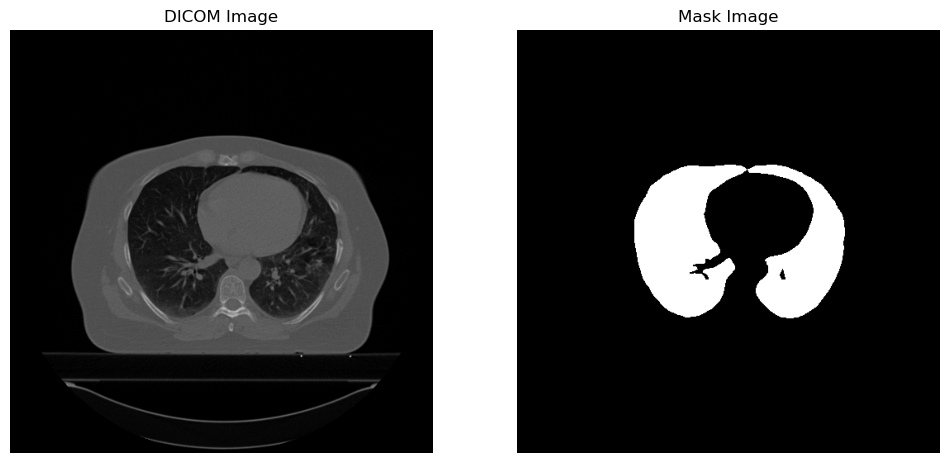

In [67]:
# Used ChatGPT to understand DataLoader and Dataset classes and fix my code
# Make a Dataset class to inherit from the Dataset class
class CustomDataset(Dataset):
    def __init__(self, dicom_dirs, mask_paths):
            self.slices = []
            self.masks = []
            self.patient_ids = []
            self.slice_location = []

            # Zip to iterate through the lists in parallel
            for dicom_dir, mask_path in zip(dicom_dirs, mask_paths):
                # Store paths to each file name in the directory path
                dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir)]
                # Read file information
                dicom_files = [pydicom.dcmread(f) for f in dicom_files]

                # Sort DICOM files by slice location
                dicom_files.sort(key=lambda x: float(x.SliceLocation))
                
                # Load mask
                # Assuming masks are stacked in the same order as slices
                mask = np.load(mask_path)['masks']  
                
                # Check that number of slices and masks match
                assert len(dicom_files) == mask.shape[0], "Mismatch in number of DICOM files and mask slices"
                
                # Append each slice and corresponding mask slice
                for dcm, seg in zip(dicom_files, mask):
                    self.slices.append(dcm.pixel_array)
                    self.masks.append(seg)
                    self.patient_ids.append(dcm.PatientID)
                    self.slice_location.append(dcm.SliceLocation)

    def __len__(self):
        assert len(self.slices) == len(self.masks), "Mismatch in number of DICOM slices and mask slices"
        return len(self.slices)

    def __getitem__(self, idx):
        # Convert numpy arrays to PyTorch tensors
        dicom_tensor = torch.from_numpy(self.slices[idx].astype(np.float32)).float()
        mask_tensor = torch.from_numpy(self.masks[idx].astype(np.float32)).float()

        #Add channel dimension at position 0 to the segmentation mask and dicom image
        dicom_tensor = dicom_tensor.unsqueeze(0)  
        mask_tensor = mask_tensor.unsqueeze(0)

        patient_id = self.patient_ids[idx]
        slice_info = self.slice_location[idx] 

        return dicom_tensor, mask_tensor, patient_id, slice_info

# Dataset path
images_path = 'Dataset/Images'
segmentation_path = 'Dataset/Segmentations/'

# List of all the full paths to directories within images_path
dicom_dirs = sorted([os.path.join(images_path, d) for d in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, d))])

# List to all of the .npz files in your segmentation_path
mask_paths = sorted([os.path.join(segmentation_path, f) for f in os.listdir(segmentation_path) if f.endswith('.npz')])

# Instantiate your dataset
dataset = CustomDataset(dicom_dirs, mask_paths)  

## Code to visualise the outputs - got ChatGPT to write it for me
# Visualise first 
dicom_tensor, mask_tensor, patient_id, slice_info = dataset[500]
print(dicom_tensor.shape, mask_tensor.shape, patient_id, slice_info)

dicom_array = dicom_tensor.squeeze().numpy()  # Remove channel dimension and convert to numpy
mask_array = mask_tensor.squeeze().numpy()    # Remove channel dimension and convert to numpy

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Set up a figure with two subplots
axes[0].imshow(dicom_array, cmap='gray')        # Display the DICOM image
axes[0].set_title('DICOM Image')                # Set title for the first subplot
axes[0].axis('off')                             # Remove axis ticks and labels

axes[1].imshow(mask_array, cmap='gray')         # Display the corresponding Mask
axes[1].set_title('Mask Image')                 # Set title for the second subplot
axes[1].axis('off')                             # Remove axis ticks and labels
plt.show()    


In [24]:
# Simple UNet architecture - created in Class
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Encoder part
        self.conv1 = self.conv_block(in_channels, 16, 3, 1, 1)
        self.maxpool1 = self.maxpool_block(2, 2, 0)
        self.conv2 = self.conv_block(16, 32, 3, 1, 1)
        self.maxpool2 = self.maxpool_block(2, 2, 0)
        self.conv3 = self.conv_block(32, 64, 3, 1, 1)
        self.maxpool3 = self.maxpool_block(2, 2, 0)

        self.middle = self.conv_block(64, 128, 3, 1, 1)

        self.upsample3 = self.transposed_block(128, 64, 3, 2, 1, 1)
        # Adding the concatenation to the upconv3
        self.upconv3 = self.conv_block(128, 64, 3, 1, 1)
        self.upsample2 = self.transposed_block(64, 32, 3, 2, 1, 1)
        self.upconv2 = self.conv_block(64, 32, 3, 1, 1)
        self.upsample1 = self.transposed_block(32, 16, 3, 2, 1, 1)
        self.upconv1 = self.conv_block(32, 16, 3, 1, 1)

        self.final = self.final_layer(16, 1, 1, 1, 0)

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
       convolution = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride=stride, padding = padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, stride=stride, padding = padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    )
       return convolution

    # Not doing anything on the number of channels - so doesn't need in/out_channels
    def maxpool_block(self, kernel_size, stride, padding):
      # Only need nn.Sequential for multiple operations in a block
       maxpool = nn.Sequential(nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Dropout2d(0.5))
       return maxpool

    def transposed_block(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
       transposed = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding = output_padding)
       return transposed

    def final_layer(self, in_channels, out_channels, kernel_size, stride, padding):
       final = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
       return final

    def forward(self, x):
        # downsampling part
        conv1 = self.conv1(x)
        maxpool1 = self.maxpool1(conv1)
        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        # middle part
        middle = self.middle(maxpool3)

        # upsampling part
        upsample3 = self.upsample3(middle)
        # Add the concats
        upconv3 = self.upconv3(torch.cat([upsample3, conv3],1))
        upsample2 = self.upsample2(upconv3)
        upconv2 = self.upconv2(torch.cat([upsample2,conv2],1))
        upsample1 = self.upsample1(upconv2)
        upconv1 = self.upconv1(torch.cat([upsample1,conv1],1))

        final_layer = self.final(upconv1)

        return final_layer

In [25]:
# Define SoftDiceLoss
class SoftDiceLoss(nn.Module):
    def __init__(self):
        # Calls the constructor of the base class (nn.Module)
        super().__init__()
        
    def forward(self, y_pred, y_true, epsilon=1e-6):
        intersection = (y_true*y_pred).sum()
        # Check the dice loss
        dice_loss = 1 - (2*intersection)/torch.sum(y_pred.pow(2) + y_true.pow(2) + epsilon)
        return dice_loss

# Define a custom loss
class CustomLoss(nn.Module):
    def __init__(self):
        # Calls the constructor of the base class (nn.Module)
        super().__init__()
        self.dice_loss = SoftDiceLoss()
        self.bce_loss = nn.BCELoss()
    
    def forward(self, y_pred, y_true):
        # Overall loss calculation
        dice_loss = self.dice_loss(y_pred, y_true)
        bce_loss = self.bce_loss(y_pred, y_true)
        custom_loss = dice_loss + bce_loss
        return custom_loss
    



Dataset size - train: 1123
Number of batches - train: 375
Dataset size - test: 562
Number of batches - test: 562
torch.Size([1, 512, 512]) torch.Size([1, 512, 512]) YZI7678 tensor(-627., dtype=torch.float64)


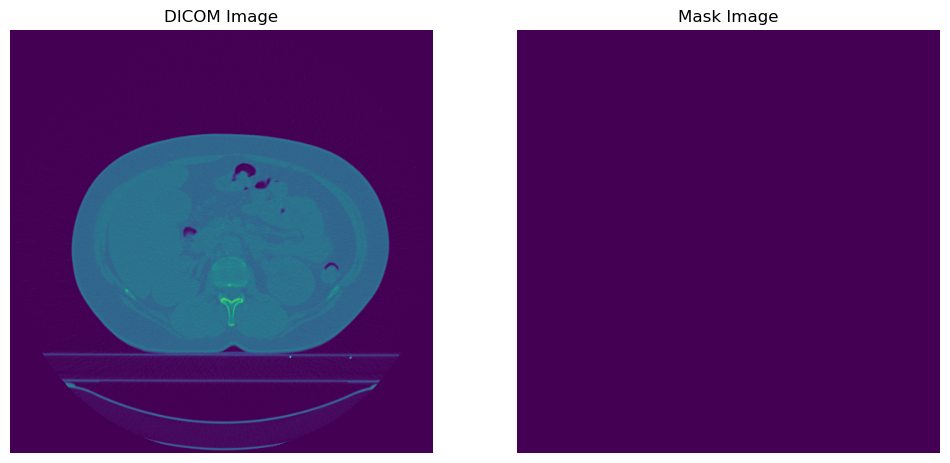

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512]) ('YZI7678',) tensor([-549.], dtype=torch.float64)


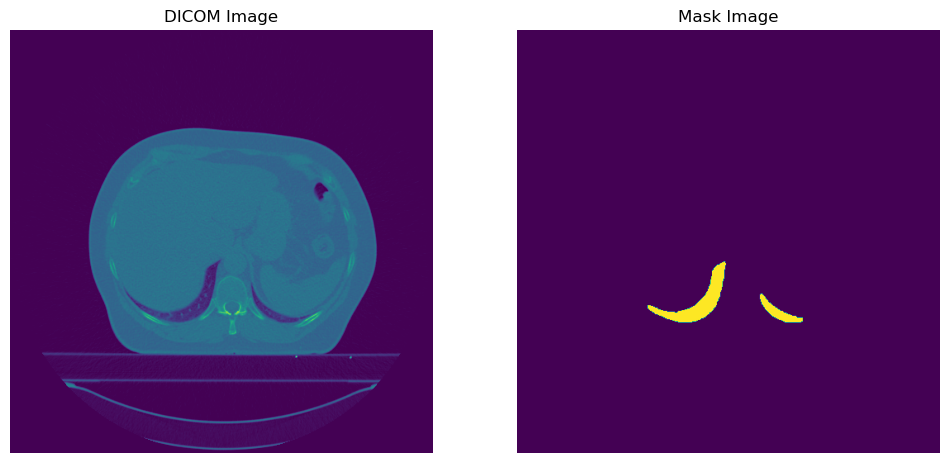

In [47]:
# Code for making train and test data_loader sets
## Train, test split
train_size = int(0.66667 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define inputs to training loop
batch_size = 3

# # Adjusting for one image
# indices = [110]
# train_dataset = Subset(train_dataset, indices)

# DataLoaders provide an iterable over our dataset and support automatic batching, sampling, shuffling, and multiprocess data loading.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Make sure the dataset is not empty
print("Dataset size - train:", len(train_loader.dataset))
print("Number of batches - train:", len(train_loader))
print("Dataset size - test:", len(test_loader.dataset))
print("Number of batches - test:", len(test_loader))


# Code to check that the training and testing images are loaded in correctly
for batch in train_loader:
    # Visualise first 
    dicom_tensor, mask_tensor, patient_id, slice_info = batch
    print(dicom_tensor[0].shape, mask_tensor[0].shape, patient_id[0], slice_info[0])
    dicom_array = dicom_tensor[0].squeeze().numpy()  
    mask_array = mask_tensor[0].squeeze().numpy()    

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  
    axes[0].imshow(dicom_array)       
    axes[0].set_title('DICOM Image')                
    axes[0].axis('off')                             

    axes[1].imshow(mask_array)         
    axes[1].set_title('Mask Image')                
    axes[1].axis('off')                            
    plt.show()   
    break 

for batch in test_loader:
    # Visualise first 
    dicom_tensor, mask_tensor, patient_id, slice_info = batch
    print(dicom_tensor.shape, mask_tensor.shape, patient_id, slice_info)

    dicom_array = dicom_tensor.squeeze().numpy()  
    mask_array = mask_tensor.squeeze().numpy()    

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  
    axes[0].imshow(dicom_array)       
    axes[0].set_title('DICOM Image')                
    axes[0].axis('off')                            

    axes[1].imshow(mask_array)         
    axes[1].set_title('Mask Image')                 
    axes[1].axis('off')                             
    plt.show()   
    break 


In [37]:
# # Parameter intialisation
# # Used ChatGPT to help me write the weights initialisation
def init_weights(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(model.weight, mode='fan_out', nonlinearity='relu')
        if model.bias is not None:
            nn.init.constant_(model.bias, 0)

# Set the random seed for reproducibility
# Used ChatGPT here
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define key data inputs
lr = 0.1 
in_channels = 1
out_channels = 1 
num_epochs = 50

# Initialise loss, model, and optimizer
model = UNet(in_channels, out_channels).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Initialise with custom loss
criterion = CustomLoss()

# Accuracy metric
binary_accuracy = BinaryAccuracy(threshold=0.5).to(device)

train_losses = []
train_accuracies = []

model.train()

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    total_loss = 0.0
    total_accuracy = 0
    total_dice = 0

    # Initialize batch counter
    batch_num = 0
    index = 0


    for images, masks, patient_ids, slice_infos in train_loader:
        # Clear old gradients in the last step
        optimizer.zero_grad()  
        
        outputs = torch.sigmoid(model(images))  

        loss = criterion(outputs, masks) 
    
        # Backward pass
        loss.backward()

        # Accumulate running loss
        total_loss += loss.item()

        # Update model parameters based on gradients
        optimizer.step()


        # Binary accuracy automatically thresholds my data
        accuracy = binary_accuracy(outputs, masks)
        total_accuracy += accuracy.item()

        # Print the epoch, batch and the loss for the current batch and accuracy for the current batch
        print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_num+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
        
        # Select the slice from the batch
        image = images[index].unsqueeze(0)  # Add batch dimension
        mask = masks[index].unsqueeze(0)    # Add batch dimension   
        image, mask = image.to(device), mask.to(device)
        output = outputs[index].unsqueeze(0)
        print(image.shape, mask.shape)
        binary_outputs = (output > 0.5).float() 

        # Plot image, label, and segmentation after every epoch
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title('Image')
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='viridis')
        plt.title('Mask')
        plt.subplot(1, 3, 3)
        plt.imshow(binary_outputs.squeeze(), cmap='viridis')
        plt.title('Segmentation')
        plt.show()

        # Update the batch number
        batch_num += 1

    # Avg loss per epoch and training loss per epoch
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = total_accuracy / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training finished')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
# Checking that the model is correct
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Channels 1 bc B/W image

model = UNet(in_channels=1, out_channels=1)

# Load the weights from a pretrained model into the 
model.load_state_dict(torch.load('Practical3/SimpleUNet_v3.pt', map_location = torch.device(device)))

# Summary of the model including the number of parameters and output size of each layer
summary(model, (1, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             160
       BatchNorm2d-2         [-1, 16, 512, 512]              32
              ReLU-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           2,320
       BatchNorm2d-5         [-1, 16, 512, 512]              32
              ReLU-6         [-1, 16, 512, 512]               0
         MaxPool2d-7         [-1, 16, 256, 256]               0
         Dropout2d-8         [-1, 16, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]           4,640
      BatchNorm2d-10         [-1, 32, 256, 256]              64
             ReLU-11         [-1, 32, 256, 256]               0
           Conv2d-12         [-1, 32, 256, 256]           9,248
      BatchNorm2d-13         [-1, 32, 256, 256]              64
             ReLU-14         [-1, 32, 2

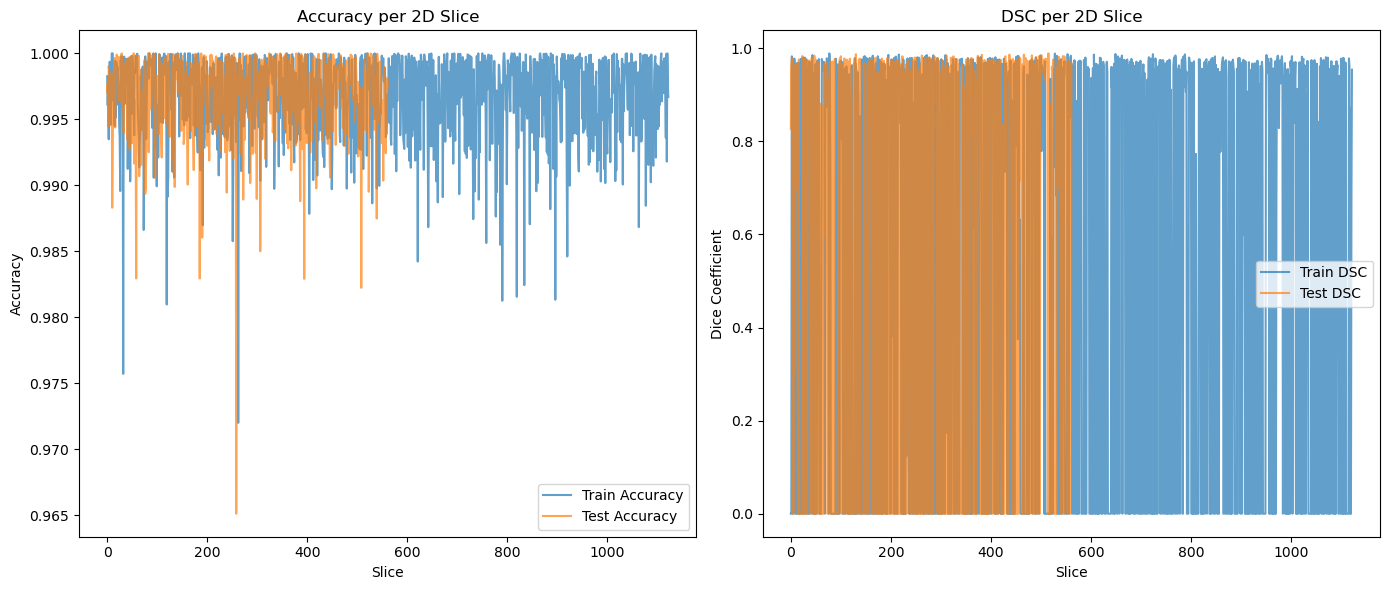

In [58]:
# Sigmoid bit
def dice_coefficient(y_pred, y_true, epsilon=1e-6):
    intersection = (y_true*y_pred).sum()
    dice_coeff = (2*intersection)/torch.sum(y_pred + y_true + epsilon)
    return dice_coeff

# Evaluation method
model.eval()    

def evaluation(loader):
    # Set model to evaluation mode
    store = []
    
    # Stop tracking gradients
    with torch.no_grad():
        for images, masks, patient_id, slice_info in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            #Add a sigmoid to the outputs to convert to probabilities
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            for slice_index in range(images.size(0)):
                # Calculate binary accuracy
                accuracy = binary_accuracy(probabilities[slice_index], masks[slice_index])

                #Calculate dice score
                dice_score = dice_coefficient(predictions[slice_index], masks[slice_index])

                # Store indices and dice score in dice store
                store.append({'patient_id': patient_id[slice_index],
                'slice_info': slice_info[slice_index],
                'accuracy': accuracy,
                'dice_score': dice_score})

    store = pd.DataFrame(store)
    return store

# Plotting
train_df = evaluation(train_loader)
test_df = evaluation(test_loader)

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_df['accuracy'], label='Train Accuracy', alpha=0.7)
plt.plot(test_df['accuracy'], label='Test Accuracy', alpha=0.7)
plt.title('Accuracy per 2D Slice')
plt.xlabel('Slice')
plt.ylabel('Accuracy')
plt.legend()

# DSC plot
plt.subplot(1, 2, 2)
plt.plot(train_df['dice_score'], label='Train DSC', alpha=0.7)
plt.plot(test_df['dice_score'], label='Test DSC', alpha=0.7)
plt.title('DSC per 2D Slice')
plt.xlabel('Slice')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

        

In [ ]:
# Plotting
train_df = evaluation(train_loader)
test_df = evaluation(test_loader)

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_df['accuracy'], label='Train Accuracy', alpha=0.7)
plt.plot(test_df['accuracy'], label='Test Accuracy', alpha=0.7)
plt.title('Accuracy per 2D Slice')
plt.xlabel('Slice')
plt.ylabel('Accuracy')
plt.legend()

# DSC plot
plt.subplot(1, 2, 2)
plt.plot(train_df['dice_score'], label='Train DSC', alpha=0.7)
plt.plot(test_df['dice_score'], label='Test DSC', alpha=0.7)
plt.title('DSC per 2D Slice')
plt.xlabel('Slice')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.tight_layout()
plt.show()